In [4]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import lightkurve as lk
plt.rcParams.update({'font.size': 18})
plt.style.use('vedant')
import sys
sys.path.append('../../WD_models/')
from sed_fitter import FitSED
from tqdm import tqdm
from scipy import stats
from astropy.table import Table

In [5]:
import P4J
import recombinator
import astropy.units as u
import pandas as pd

In [6]:
ztf = Table.read('ztf_lc.fits')

In [23]:
np.unique(ztf['filtercode'])

zg
zr


(array([ 13.,  35.,  58.,  85., 126., 104., 107.,  84.,  62.,  54.,  38.,
         20.,   8.,   9.,  10.,   5.,   4.,   0.,   2.,   3.,   0.,   0.,
          0.,   1.,   1.]),
 array([0.215     , 0.31092   , 0.40684   , 0.50276   , 0.59868   ,
        0.6946    , 0.79051995, 0.88644   , 0.98236   , 1.07828   ,
        1.1741999 , 1.2701199 , 1.36604   , 1.46196   , 1.5578799 ,
        1.6538    , 1.74972   , 1.84564   , 1.9415599 , 2.0374799 ,
        2.1334    , 2.22932   , 2.32524   , 2.42116   , 2.5170798 ,
        2.613     ], dtype=float32),
 <BarContainer object of 25 artists>)

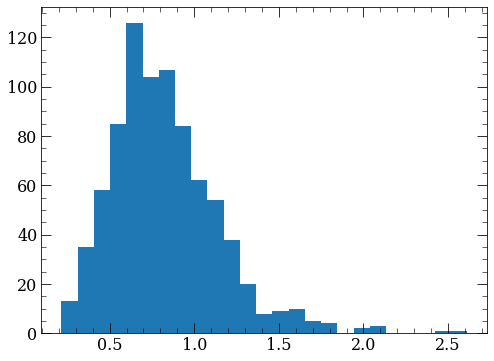

In [26]:
plt.hist(ztf['chi'])

In [154]:
c1 = -373.60266
c2 = 1.2290856976862374


clean = (
    (ztf['catflags'] == 0)*
    (ztf['ra'] > 324.61254)*
    (ztf['ra'] < 324.612662)*
    (ztf['chi'] < 1.9)*
    (ztf['dec'] < c1 + c2 * ztf['ra'] )
)

g = ztf['filtercode'] == 'zg'
r = ztf['filtercode'] == 'zr'

In [155]:
stats.linregress(ztf['ra'][clean], ztf['dec'][clean])

LinregressResult(slope=1.3248270698629334, intercept=-404.6815887051605, rvalue=0.8163982860882075, pvalue=4.623680080039376e-180, stderr=0.03431085990342718)

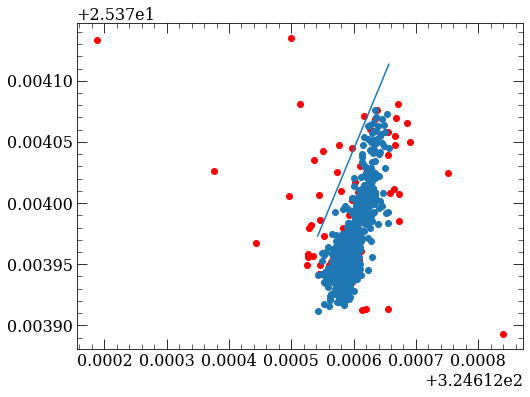

In [157]:
ragrid = np.linspace(np.min(ztf['ra'][clean]), np.max(ztf['ra'][clean]))
plt.scatter(ztf['ra'][~clean], ztf['dec'][~clean], color = 'r')
plt.scatter(ztf['ra'][clean], ztf['dec'][clean])

plt.plot(ragrid, c1 + c2 * ragrid)

In [185]:
ztfg = ztf[clean * g]
ztfr = ztf[clean * r]

### Light Curves

<ErrorbarContainer object of 3 artists>

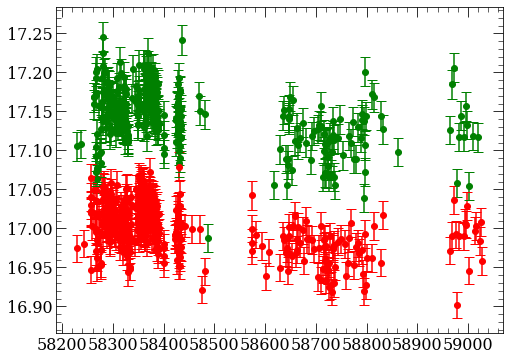

In [160]:
plt.errorbar(ztfg['mjd'], ztfg['mag'], yerr = ztfg['magerr'],
            linestyle = 'none', marker = 'o', color = 'g')

plt.errorbar(ztfr['mjd'], ztfr['mag'], yerr = ztfr['magerr'],
            linestyle = 'none', marker = 'o', color = 'r')

In [164]:
mjd = ztfg['mjd']
mags = ztfg['mag']
e_mags = ztfg['magerr']

In [177]:
my_per = P4J.periodogram(method = 'MHAOV')

my_per.set_data(mjd, mags, e_mags, Nharmonics = 1)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=1, fresolution=1e-5)
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=5)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies()

pbest_data = pbest[0]

print(fbest)
print(1 / fbest)

fbest = [0.14661]

[0.99874 0.99877 0.99882 0.9987  0.00179]
[  1.0012616   1.0012316   1.0011814   1.0013016 558.65924  ]


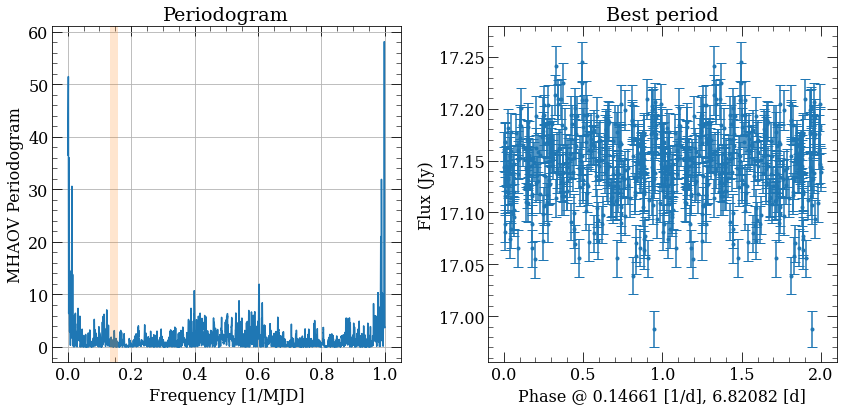

In [178]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('MHAOV Periodogram')
plt.title('Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([mags[idx], mags[idx]]),
            np.concatenate([e_mags[idx], e_mags[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Flux (Jy)')
plt.tight_layout();

In [180]:
lc = lk.LightCurve(mjd, mags, e_mags)

<AxesSubplot:xlabel='Phase', ylabel='Flux'>

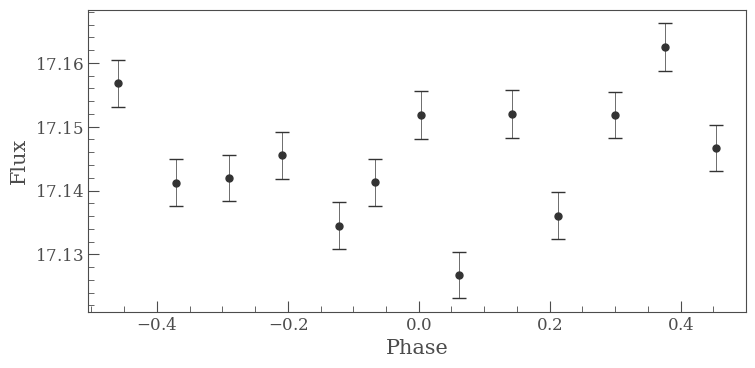

In [184]:
lc.fold(6.82).bin(25).errorbar(marker = 'o', markersize = 5)

### Color Curve

In [219]:
def prop_error(e_mags):
    return np.sqrt(np.sum(e_mags**2)) / len(e_mags)

In [235]:
nbin = 5

gbins = stats.binned_statistic(ztfg['mjd'], ztfg['mag'], statistic = 'mean', bins = nbin)
e_gbins = stats.binned_statistic(ztfg['mjd'], ztfg['magerr'], statistic = prop_error, bins = gbins.bin_edges)

rbins = stats.binned_statistic(ztfr['mjd'], ztfr['mag'], statistic = 'mean', bins = gbins.bin_edges)
e_rbins = stats.binned_statistic(ztfr['mjd'], ztfr['magerr'], statistic = prop_error, bins = gbins.bin_edges)

<ErrorbarContainer object of 3 artists>

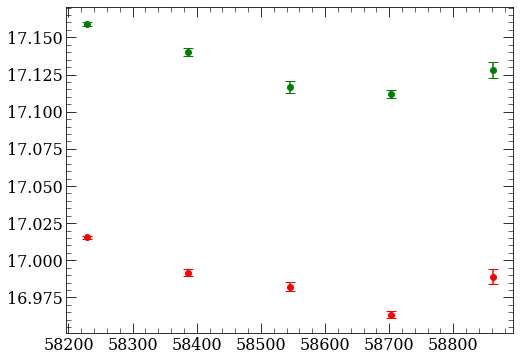

In [236]:
plt.errorbar(gbins.bin_edges[:-1], gbins.statistic, color = 'g', yerr = e_gbins.statistic,
            linestyle = 'none', marker = 'o')
plt.errorbar(rbins.bin_edges[:-1], rbins.statistic, color = 'r', yerr = e_rbins.statistic,
            linestyle = 'none', marker = 'o')

<ErrorbarContainer object of 3 artists>

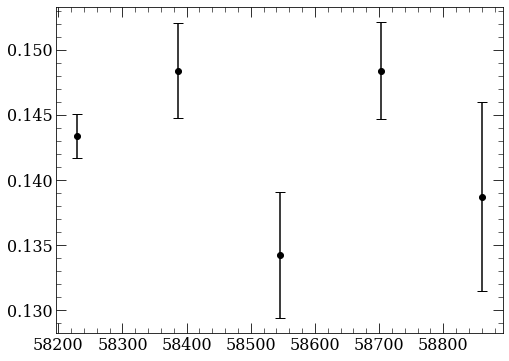

In [237]:
plt.errorbar(gbins.bin_edges[:-1], gbins.statistic - rbins.statistic, color = 'k', 
             yerr = np.sqrt(e_rbins.statistic**2 + e_gbins.statistic**2),
            linestyle = 'none', marker = 'o')